In [1]:
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import os
from os.path import join
import datetime as dt
from scipy.stats.stats import pearsonr
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.cross_validation import StratifiedKFold
import itertools
from scipy.stats import kendalltau
import random
import nltk
random.seed(123)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
plt.style.use('ggplot')

In [3]:
data = pd.read_csv('winemag-data_first150k.csv')
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


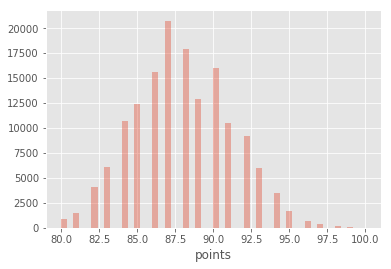

In [4]:
sns.distplot(data.points, kde=False)

In [5]:
def GoodRating(row):
    if row['points'] >= 89:
        val = 1
    else:
        val = 0
    return(val)
data['Good'] = data.apply(GoodRating, axis=1)
data.head()
#data.shape (15k,12)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,Good
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,1
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,1
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,1
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,1


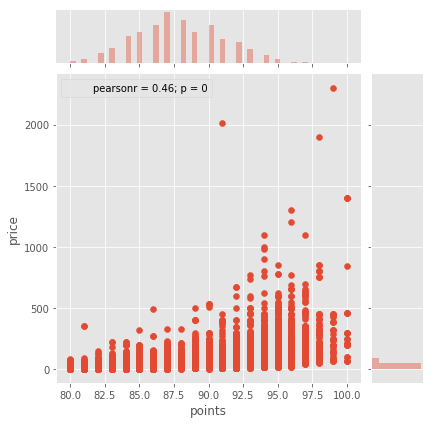

In [6]:
sns.jointplot(x='points', y='price', data=data)

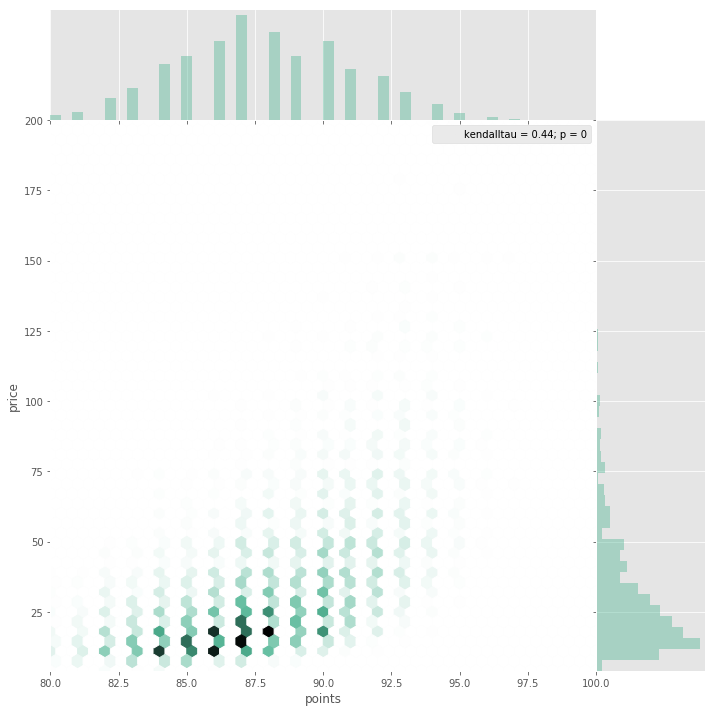

In [7]:
a = data
a = a[a.price <= 200]
sns.jointplot(x='points',y='price',stat_func=kendalltau,kind="hex", color="#4CB391",space=0,size=10,data=a)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


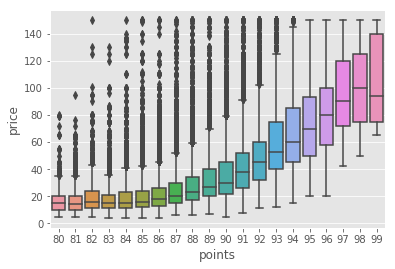

In [8]:
a = data[data.price <= 150][data.points < 100]
sns.boxplot(x = 'points', y = 'price', data = a)

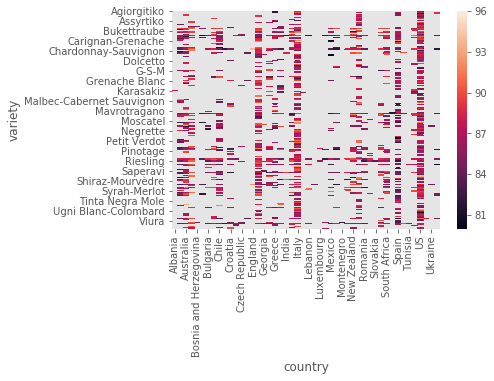

In [9]:
wines = data.pivot_table(values='points',index=['variety'],columns=['country'],aggfunc='mean')
wines.head()
sns.heatmap(wines)

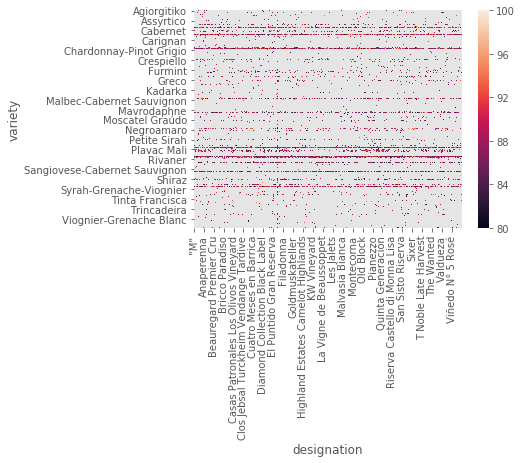

In [10]:
wines = data.pivot_table(values='points',index=['variety'],columns=['designation'],aggfunc='mean')
wines.head()
sns.heatmap(wines)

In [11]:
df = data.sample(n=9000)
df = df[['description','Good']]
df.head()

,description,Good
92175,This is an unusual blend of Croatian and inter...,0
125253,Shows the classic faults with hot country Peti...,0
91391,"Slightly grassy and pungent on the nose, but t...",0
147481,"Solidly made, in a light, tart, true-to-variet...",0
43313,"Made in an immediately appealing style, this P...",1


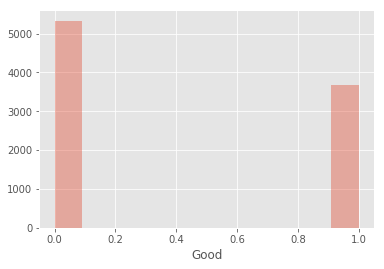

In [12]:
sns.distplot(df.Good, kde=False)

In [13]:
def split_into_lemmas(message):
    message = str(message).lower()
    words = TextBlob(message).words
    return [word.lemma for word in words]

BOW_transform = CountVectorizer(analyzer=split_into_lemmas).fit(df['description'])

In [14]:
BOW = BOW_transform.transform(df['description'])

In [15]:
tfidf_BOW = TfidfTransformer().fit(BOW)

In [16]:
print('inverse document frequnency of the word "to" is:', tfidf_BOW.idf_[BOW_transform.vocabulary_['fruit']])

inverse document frequnency of the word "to" is: 1.92393010323


In [17]:
converted_messages = tfidf_BOW.transform(BOW)

In [18]:
t1 = dt.datetime.now()
spam_detector = MultinomialNB().fit(converted_messages, df['Good'])
t2 = dt.datetime.now()
print('total time taken in training:', (t2-t1))

total time taken in training: 0:00:00.006493


In [19]:
#print('predicted:', spam_detector.predict(tfidf_BOW.transform(BOW[120]))[0])
#print('expected:', df['Good'][120])

In [20]:
target = np.array(df['Good'].tolist())
features = converted_messages
skf = StratifiedKFold(target, n_folds=5)

In [21]:
true_ = []
pred_ = []
for train_index, test_index in skf:
    spam_detector = MultinomialNB().fit(converted_messages[train_index], target[train_index])
    predict = spam_detector.predict(converted_messages[test_index])
    true_.append(target[test_index])
    pred_.append(predict)

In [22]:
TrueLabel = list(itertools.chain(*true_))
PredictedLabel = list(itertools.chain(*pred_))

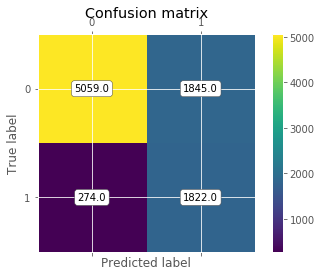

In [23]:
cm = confusion_matrix(PredictedLabel, TrueLabel)
fig, ax = plt.subplots()
im = ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
plt.title('Confusion matrix')
fig.colorbar(im)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
TrueLabel = [1 if x==1 else 0 for x in TrueLabel]
PredictedLabel = [1 if x==1 else 0 for x in PredictedLabel]

In [25]:
print('Correlation between the actual and prediction is:', pearsonr(TrueLabel, PredictedLabel)[0], 'with p-value',  ("%.2f" % pearsonr(TrueLabel, PredictedLabel)[1]))

Correlation between the actual and prediction is: 0.517879826949 with p-value 0.00


In [26]:
target_names = ['Good Wine', 'Bad Wine']
print(classification_report(TrueLabel, PredictedLabel, target_names=target_names))

             precision    recall  f1-score   support

  Good Wine       0.73      0.95      0.83      5333
   Bad Wine       0.87      0.50      0.63      3667

avg / total       0.79      0.76      0.75      9000



In [27]:

print('Area under the curve (AUC) is:', roc_auc_score(TrueLabel, PredictedLabel))

Area under the curve (AUC) is: 0.722742855162


In [28]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(TrueLabel, PredictedLabel)
roc_auc = auc(false_positive_rate, true_positive_rate)

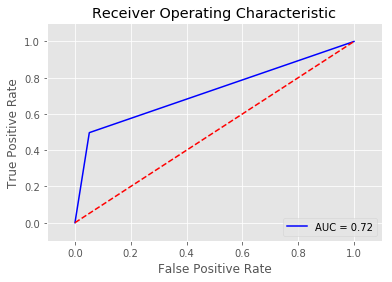

In [29]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Lots of code from
#https://github.com/shubhabrataroy/Thinkful/blob/master/Curriculum/SpamFilter.ipynb

In [30]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,Good
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,1
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,1
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,1
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,1


In [31]:
good = data[data.Good == 1]
bad = data[data.Good == 0]

In [70]:
goodString = ' '.join(good['description'].tolist()).lower()
badString = ' '.join(bad['description'].tolist()).lower()
goodTokens = nltk.tokenize.word_tokenize(goodString)
badTokens = nltk.tokenize.word_tokenize(badString)

In [71]:
goodDist = nltk.FreqDist(goodTokens)
badDist = nltk.FreqDist(badTokens)

In [73]:
stopwords = nltk.corpus.stopwords.words('english')

In [78]:
good_filter = lambda goodDist, stopwords: dict( (word,goodDist[word]) for word in goodDist if word not in stopwords )
good_word_freq = dict_filter(goodDist, stopwords)

In [79]:
bad_filter = lambda goodDist, stopwords: dict( (word,badDist[word]) for word in badDist if word not in stopwords )
bad_word_freq = dict_filter(badDist, stopwords)

In [98]:
Good = pd.DataFrame(list(good_word_freq.items()))
Good.columns = ['word','count']
Bad = pd.DataFrame(list(bad_word_freq.items()))
Bad.columns = ['word','count']

In [106]:
Good.sort_values('count',ascending=False).head(20)

,word,count
20,",",260577
11,.,179042
4,wine,42762
101,'s,32294
54,flavors,28720
14,fruit,26018
24,tannins,17254
32,finish,14535
136,acidity,14204
38,ripe,14151


In [107]:
Bad.sort_values('count',ascending=False).head(20)

,word,count
1,",",287513
13,.,226614
12,flavors,49109
7,wine,47733
14,'s,40422
43,fruit,30488
200,finish,23189
38,aromas,23001
32,acidity,18399
49,palate,18112


In [82]:
from sklearn.tree import DecisionTreeClassifier

In [91]:
def QualityRating(row):
    if row['points'] >= 90:
        val = 1
    else:
        val = 0
    return(val)

In [92]:
wine_df = data
wine_df=wine_df.loc[wine_df.country=='US',['points','price','region_1', 'variety','winery']]
wine_df=wine_df.dropna(axis=0,how='any')
wine_df['point_bins'] = data.apply(QualityRating,axis=1)

In [93]:
wine_df['is_train'] = np.random.uniform(0, 1, len(wine_df)) <= .25
wine_train, wine_test = wine_df[wine_df['is_train']==True], wine_df[wine_df['is_train']==False]

In [94]:
# Train classification tree
x = wine_train.loc[:,['price','regn_enc','var_enc','wnry_enc']]
y = wine_train['point_bins']
min_samp_split = 2                           
clf = DecisionTreeClassifier(min_samples_split=min_samp_split,max_features=None)
clf = clf.fit(x,y)

# Report classification results.  training dataset first, then test.  
# BASELINE - all features, no tree termination criteria
train_error=y==clf.predict(x)
test_error=wine_test['point_bins']==clf.predict(wine_test.loc[:,['price', \
    'regn_enc','var_enc','wnry_enc']])
print('@@@@@@@@@@@@@@@@@@@@@@@@@')
print('CART w/ #leaf nodes = ',clf.tree_.node_count) 
print('   ',clf.n_features_,' features out of: 4 features')                          
print('   training accuracy: ','{:.1%}'.format(sum(train_error)/len(
    train_error)))
print('   test accuracy: ','{:.1%}'.format(sum(test_error)/len(test_error)))



ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

ValueError: could not convert string to float: 'France'

In [74]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df['species'] = pd.Factor(iris.target, iris.target_names)
df.head()

train, test = df[df['is_train']==True], df[df['is_train']==False]

features = df.columns[:4]
clf = RandomForestClassifier(n_jobs=2)
y, _ = pd.factorize(train['species'])
clf.fit(train[features], y)

9

In [68]:
train.head()


,country,designation,points,price,region_1,variety,winery,Good,is_train
3,US,Reserve,96,65.0,Willamette Valley,Pinot Noir,Ponzi,1,True
65,US,Estate Select,91,36.0,Santa Clara Valley,Syrah,Jason-Stephens,1,True
73,US,NaN,91,19.0,Willamette Valley,Pinot Gris,Trinity Vineyards,1,True
74,Portugal,Premium,91,15.0,NaN,Portuguese Red,Adega Cooperativa de Borba,1,True
100,US,NaN,86,24.0,South Coast,Viognier,Hawk Watch Winery,0,True


In [95]:
## From https://github.com/dasotelo/Python_Projects/blob/master/Wine_Bag_Boost.py
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Read in & munge wine information dataset.  US wines only
wine_df=pd.read_csv('winemag-data_first150k.csv')
wine_df=wine_df.loc[wine_df.country=='US',['points','price','region_1', \
    'variety','winery']]
wine_df=wine_df.dropna(axis=0,how='any')

# Map point values to categories
bin_map={
    100:'90+',
    99:'90+',
    98:'90+',
    97:'90+',
    96:'90+',
    95:'90+',
    94:'90+',
    93:'90+',
    92:'90+',
    91:'90+',
    90:'90+',
    89:'<90',
    88:'<90',
    87:'<90',
    86:'<90',
    85:'<90',
    84:'<90',
    83:'<90',
    82:'<90',
    81:'<90',
    80:'<90',
    79:'<90',
    78:'<90',
    77:'<90',
    76:'<90'}
wine_df['point_bins']=wine_df.points.map(bin_map)
wine_df.point_bins.unique() # Ensure no records are un-binned
wine_df=wine_df.drop('points',axis=1)

#Prepare data for classification by labeling category data
regn_lab=LabelEncoder().fit(np.unique(wine_df.region_1.values))
var_lab=LabelEncoder().fit(np.unique(wine_df.variety.values))
wnry_lab=LabelEncoder().fit(np.unique(wine_df.winery.values))
wine_df['regn_enc']=regn_lab.transform(wine_df.region_1)
wine_df['var_enc']=var_lab.transform(wine_df.variety)
wine_df['wnry_enc']=wnry_lab.transform(wine_df.winery)
wine_df=wine_df.drop(['region_1','variety','winery'],axis=1)

# Split into 70/30 train/test datasets and set up training variables
wine_train,wine_test=train_test_split(wine_df,test_size=0.30)
x=wine_train.loc[:,['price','regn_enc','var_enc','wnry_enc']]
y=wine_train['point_bins']

# Train classification tree                
clf=DecisionTreeClassifier(max_features=None)
clf=clf.fit(x,y)

# Report classification results.  training dataset first, then test.  
train_error=y==clf.predict(x)
test_error=wine_test['point_bins']==clf.predict(wine_test.loc[:,['price', \
    'regn_enc','var_enc','wnry_enc']])
print('@@@@@@@@@@@@@@@@@@@@@@@@@')
print('CART w/ #leaf nodes = ',clf.tree_.node_count) 
print('   ',clf.n_features_,' features out of: 4 features')                          
print('   training accuracy: ','{:.1%}'.format(sum(train_error)/len(
    train_error)))
print('   test accuracy: ','{:.1%}'.format(sum(test_error)/len(test_error)))

# Control the number of n_estimators in ensemble functions
max_n_ests=25

# Create dataframe to record results of ensembles.
results=pd.DataFrame([],columns=list(['type','n_leaf','n_est', \
    'train_acc','test_acc']))

# Train bagging ensemble on iterations of n_estimators=i
# and iterations of stump max_leaf_nodes=j
for j in [500,2000,8000,99999]:
    clf_stump=DecisionTreeClassifier(max_features=None,max_leaf_nodes=j)
    for i in np.arange(1,max_n_ests):
        print(i)
        baglfy=BaggingClassifier(base_estimator=clf_stump,n_estimators=i,
            max_samples=1.0)
        baglfy=baglfy.fit(x,y)
        bag_tr_err=y==baglfy.predict(x)
        bag_tst_err=wine_test['point_bins']==baglfy.predict( \
            wine_test.loc[:,['price','regn_enc','var_enc','wnry_enc']])
        run_rslt=pd.DataFrame([['bag',j,i,sum(bag_tr_err)/len(bag_tr_err),
            sum(bag_tst_err)/len(bag_tst_err)]],
            columns=list(['type','n_leaf','n_est','train_acc','test_acc']))
        results=results.append(run_rslt)

# Train boosting ensemble on iterations of n_estimators=i
# and iterations of stump max_leaf_nodes=j
for j in [500,2000,8000,99999]:
    clf_stump=DecisionTreeClassifier(max_features=None,max_leaf_nodes=j)
    for i in np.arange(1,max_n_ests):
        print(i)
        bstlfy=AdaBoostClassifier(base_estimator=clf_stump,n_estimators=i)
        bstlfy=bstlfy.fit(x,y)
        bst_tr_err=y==bstlfy.predict(x)
        bst_tst_err=wine_test['point_bins']==bstlfy.predict( \
            wine_test.loc[:,['price','regn_enc','var_enc','wnry_enc']])
        run_rslt=pd.DataFrame([['bst',j,i,sum(bst_tr_err)/len(bst_tr_err),
            sum(bst_tst_err)/len(bst_tst_err)]],
            columns=list(['type','n_leaf','n_est','train_acc','test_acc']))
        results=results.append(run_rslt)

# Plot Bagging accuracy results on test data
# 500 leaf stumps
plt.plot(results.loc[((results.type=='bag')&(results.n_leaf==500)), \
    ['n_est']],results.loc[((results.type=='bag')&(results.n_leaf==500)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#4da6ff', \
    label='Bagging w/ 500 leaf stump')
# 2000 leaf stumps
plt.plot(results.loc[((results.type=='bag')&(results.n_leaf==2000)), \
    ['n_est']],results.loc[((results.type=='bag')&(results.n_leaf==2000)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#0080ff', \
    label='Bagging w/ 2000 leaf stump')
# 8000 leaf stumps
plt.plot(results.loc[((results.type=='bag')&(results.n_leaf==8000)), \
    ['n_est']],results.loc[((results.type=='bag')&(results.n_leaf==8000)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#0059b3', \
    label='Bagging w/ 8000 leaf stump')
# Full Classification Trees (no early termination)
plt.plot(results.loc[((results.type=='bag')&(results.n_leaf==99999)), \
    ['n_est']],results.loc[((results.type=='bag')&(results.n_leaf==99999)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#003366', \
    label='Bagging w/ full tree')
# Plot test accuracy of baseline classification tree
clf_test_acc=sum(test_error)/len(test_error)
plt.plot([1,max_n_ests],[clf_test_acc,clf_test_acc],color='k', \
    label='Baseline classification tree')
plt.legend(fontsize=8)
plt.title('Bagging Test Sample Accuracy on n_estimators')
plt.ylim([results.loc[results.type=='bag',['test_acc']].values.min()-0.01, \
    results.loc[results.type=='bag',['test_acc']].values.max()+0.01])
plt.ylabel('Test Accuracy%')
plt.xlabel('n_estimators')
plt.show()

# Plot Boosting accuracy results on test data
# 500 leaf stumps
plt.plot(results.loc[((results.type=='bst')&(results.n_leaf==500)), \
    ['n_est']],results.loc[((results.type=='bst')&(results.n_leaf==500)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#ff704d', \
    label='Boosting w/ 500 leaf stump')
# 2000 leaf stumps
plt.plot(results.loc[((results.type=='bst')&(results.n_leaf==2000)), \
    ['n_est']],results.loc[((results.type=='bst')&(results.n_leaf==2000)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#ff3300', \
    label='Boosting w/ 2000 leaf stump')
# 8000 leaf stumps
plt.plot(results.loc[((results.type=='bst')&(results.n_leaf==8000)), \
    ['n_est']],results.loc[((results.type=='bst')&(results.n_leaf==8000)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#b32400', \
    label='Boosting w/ 8000 leaf stump')
# Full Classification Trees (no early termination)
plt.plot(results.loc[((results.type=='bst')&(results.n_leaf==99999)), \
    ['n_est']],results.loc[((results.type=='bst')&(results.n_leaf==99999)), \
    ['test_acc']],linestyle='--',linewidth=2,color='#661400', \
    label='Boosting w/ full tree')
# Plot test accuracy of baseline classification tree
plt.plot([1,max_n_ests],[clf_test_acc,clf_test_acc],color='k', \
    label='Baseline classification tree')
plt.legend(fontsize=8)
plt.title('Boosting Test Sample Accuracy on n_estimators')
plt.ylim([results.loc[results.type=='bst',['test_acc']].values.min()-0.01, \
    results.loc[results.type=='bst',['test_acc']].values.max()+0.01])
plt.ylabel('Test Accuracy%')
plt.xlabel('n_estimators')
plt.show()

# ROC curve for baseline classification tree
clf_probs=clf.predict_proba(wine_test.loc[:,['price','regn_enc','var_enc', \
    'wnry_enc']])
fpr1,tpr1,thr1=roc_curve(np.where(wine_test['point_bins']=='90+',1.,0.), \
    clf_probs[:,0])
# ROC curve for bagging ensemble using full classification trees
bag_probs=baglfy.predict_proba(wine_test.loc[:,['price','regn_enc', \
    'var_enc','wnry_enc']])
fpr2,tpr2,thr2=roc_curve(np.where(wine_test['point_bins']=='90+',1.,0.), \
    bag_probs[:,0])
# ROC curve for boosting ensemble using full classification trees
bst_probs=bstlfy.predict_proba(wine_test.loc[:,['price','regn_enc', \
    'var_enc','wnry_enc']])
fpr3,tpr3,thr3=roc_curve(np.where(wine_test['point_bins']=='90+',1.,0.), \
    bst_probs[:,0])

# Plot ROC Curves
plt.plot(fpr1,tpr1,color='#4d4d33',label='Baseline CART')
plt.plot(fpr2,tpr2,color='#0080ff',label='Bagging Ensemble')
plt.plot(fpr3,tpr3,color='#ff3300',label='Boosting Ensemble')
plt.plot([0.,1.],[0.,1.],color='k',linestyle='--')
plt.title('ROC Curves for 90+ Point Wine Classification')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(fontsize=8)
plt.show()

@@@@@@@@@@@@@@@@@@@@@@@@@
CART w/ #leaf nodes =  17769
    4  features out of: 4 features
   training accuracy:  95.0%
   test accuracy:  81.2%
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


KeyboardInterrupt: 

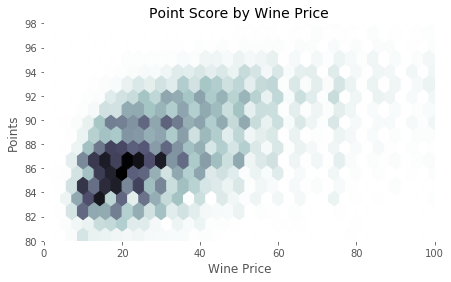

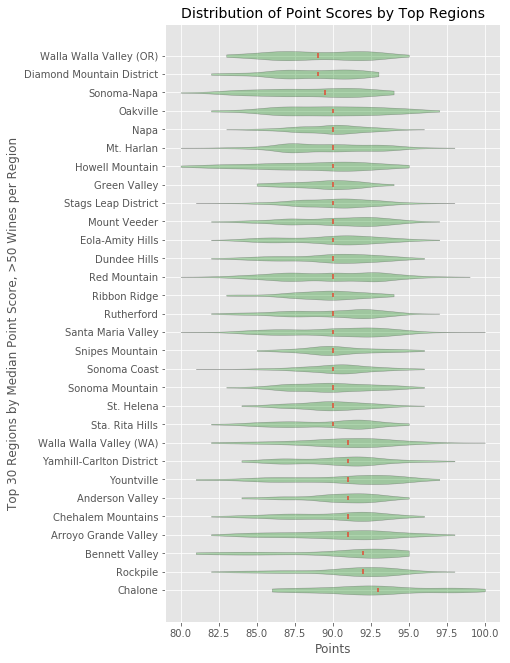

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

@@@@@@@@@@@@@@@@@@@@@@@@@
CART w/ #leaf nodes =  20249
    4  features out of: 4 features
   training accuracy:  94.6%
   test accuracy:  82.4%
@@@@@@@@@@@@@@@@@@@@@@@@@
Feature importance for max_leaves model
      price  regn_enc  var_enc  wnry_enc
0  0.376813  0.144686  0.11842  0.360081
@@@@@@@@@@@@@@@@@@@@@@@@@
CART w/ #leaf nodes =  19507
   Varietal information removed
   training accuracy:  92.3%
   test accuracy:  81.2%
@@@@@@@@@@@@@@@@@@@@@@@@@
CART w/ #leaf nodes =  20647
   Region information removed
   training accuracy:  93.4%
   test accuracy:  81.6%
@@@@@@@@@@@@@@@@@@@@@@@@@
CART w/ #leaf nodes =  18701
   Varietal & Region information removed
   training accuracy:  90.0%
   test accuracy:  80.3%
20241
20141
20041
19941
19841
19741
19641
19541
19441
19341
19241
19141
19041
18941
18841
18741
18641
18541
18441
18341
18241
18141
18041
17941
17841
17741
17641
17541
17441
17341
17241
17141
17041
16941
16841
16741
16641
16541
16441
16341
16241
16141
16041
15941
15841
15741
15

KeyboardInterrupt: 

In [96]:
# From https://github.com/dasotelo/Python_Projects/blob/master/Wine_classify.py
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Read in & munge wine information dataset.  US wines only
wine_df=pd.read_csv('winemag-data_first150k.csv')
wine_df=wine_df.loc[wine_df.country=='US',['points','price','region_1', \
    'variety','winery']]
wine_df=wine_df.dropna(axis=0,how='any')

# Hexbin of points on price
plt.figure(figsize=(7,4))
plt.hexbin(wine_df.price,wine_df.points,cmap='bone_r',gridsize=35,
    extent=(0,100,73,115))
plt.xlim(0,100)
plt.ylim(80,98)
plt.title('Point Score by Wine Price',size=14)
plt.ylabel('Points')
plt.xlabel('Wine Price')
plt.show()

# Violin plot of points on region - use regions with 50 or more wines only
vio_dfm=wine_df.loc[:,['region_1','points']].groupby('region_1').median()
vio_dfm.reset_index(inplace=True)
vio_df=wine_df.loc[:,['region_1','points']].groupby('region_1').count()
vio_df.reset_index(inplace=True)
vio_df=vio_df.merge(vio_dfm,'inner',left_on='region_1',right_on='region_1')
vio_df=vio_df.sort_values('points_y',ascending=False)
vio_df=vio_df.loc[vio_df.points_x>=50,:]
vio_df=vio_df.iloc[0:30,0]

vio_df2=[wine_df.loc[wine_df.region_1==j,['points']] for j in vio_df.values]

plt.figure(figsize=(6,11))
parts=plt.violinplot(vio_df2,vert=False,showextrema=False,showmedians=True)
for pc in parts['bodies']:
    pc.set_edgecolor('black')
    pc.set_alpha(0.3)
    pc.set_facecolor('green')
plt.yticks(np.arange(30,0,-1),vio_df.values)
plt.title('Distribution of Point Scores by Top Regions',size=14)
plt.ylabel('Top 30 Regions by Median Point Score, >50 Wines per Region')
plt.xlabel('Points')
plt.show()

# Map point values to categories
bin_map={
    100:'90+',
    99:'90+',
    98:'90+',
    97:'90+',
    96:'90+',
    95:'90+',
    94:'90+',
    93:'90+',
    92:'90+',
    91:'90+',
    90:'90+',
    89:'<90',
    88:'<90',
    87:'<90',
    86:'<90',
    85:'<90',
    84:'<90',
    83:'<90',
    82:'<90',
    81:'<90',
    80:'<90',
    79:'<90',
    78:'<90',
    77:'<90',
    76:'<90'}
wine_df['point_bins']=wine_df.points.map(bin_map)
wine_df.point_bins.unique() # Ensure no records are un-binned
wine_df=wine_df.drop('points',axis=1)

# Split into 50/50 train/test datasets
wine_train,wine_test=train_test_split(wine_df,test_size=0.15)

# Prepare train data for classification tree
regn_lab=LabelEncoder().fit(np.unique(wine_df.region_1.values))
var_lab=LabelEncoder().fit(np.unique(wine_df.variety.values))
wnry_lab=LabelEncoder().fit(np.unique(wine_df.winery.values))
wine_train['regn_enc']=regn_lab.transform(wine_train.region_1)
wine_train['var_enc']=var_lab.transform(wine_train.variety)
wine_train['wnry_enc']=wnry_lab.transform(wine_train.winery)
wine_train=wine_train.drop(['region_1','variety','winery'],axis=1)

# Prepare test data for classification tree
wine_test['regn_enc']=regn_lab.transform(wine_test.region_1)
wine_test['var_enc']=var_lab.transform(wine_test.variety)
wine_test['wnry_enc']=wnry_lab.transform(wine_test.winery)
wine_test=wine_test.drop(['region_1','variety','winery'],axis=1)

# Train classification tree
x=wine_train.loc[:,['price','regn_enc','var_enc','wnry_enc']]
y=wine_train['point_bins']
min_samp_split=2                           
clf=DecisionTreeClassifier(min_samples_split=min_samp_split,max_features=None)
clf=clf.fit(x,y)

# Report classification results.  training dataset first, then test.  
# BASELINE - all features, no tree termination criteria
train_error=y==clf.predict(x)
test_error=wine_test['point_bins']==clf.predict(wine_test.loc[:,['price', \
    'regn_enc','var_enc','wnry_enc']])
print('@@@@@@@@@@@@@@@@@@@@@@@@@')
print('CART w/ #leaf nodes = ',clf.tree_.node_count) 
print('   ',clf.n_features_,' features out of: 4 features')                          
print('   training accuracy: ','{:.1%}'.format(sum(train_error)/len(
    train_error)))
print('   test accuracy: ','{:.1%}'.format(sum(test_error)/len(test_error)))

# Report feature importance
print('@@@@@@@@@@@@@@@@@@@@@@@@@')
print('Feature importance for max_leaves model')
print(pd.DataFrame([clf.feature_importances_],columns=x.columns.values))

# Train classification tree - remove varietal information
x=wine_train.loc[:,['price','regn_enc','wnry_enc']]
y=wine_train['point_bins']
min_samp_split=2                           
clf=DecisionTreeClassifier(min_samples_split=min_samp_split,max_features=None)
clf=clf.fit(x,y)

# Report classification results.  train first, then test.  
# Varietal information removed - no tree termination criteria
train_error=y==clf.predict(x)
test_error=wine_test['point_bins']==clf.predict(wine_test.loc[:,['price', \
    'regn_enc','wnry_enc']])
print('@@@@@@@@@@@@@@@@@@@@@@@@@')
print('CART w/ #leaf nodes = ',clf.tree_.node_count) 
print('   Varietal information removed')                          
print('   training accuracy: ','{:.1%}'.format(sum(train_error)/len(
    train_error)))
print('   test accuracy: ','{:.1%}'.format(sum(test_error)/len(test_error)))

# Train classification tree - remove region information
x=wine_train.loc[:,['price','var_enc','wnry_enc']]
y=wine_train['point_bins']
min_samp_split=2                           
clf=DecisionTreeClassifier(min_samples_split=min_samp_split,max_features=None)
clf=clf.fit(x,y)

# Report classification results.  train first, then test.  
# Region information removed - no tree termination criteria
train_error=y==clf.predict(x)
test_error=wine_test['point_bins']==clf.predict(wine_test.loc[:,['price', \
    'var_enc','wnry_enc']])
print('@@@@@@@@@@@@@@@@@@@@@@@@@')
print('CART w/ #leaf nodes = ',clf.tree_.node_count) 
print('   Region information removed')                          
print('   training accuracy: ','{:.1%}'.format(sum(train_error)/len(
    train_error)))
print('   test accuracy: ','{:.1%}'.format(sum(test_error)/len(test_error)))

# Train classification tree - remove varietal & region information
x=wine_train.loc[:,['price','wnry_enc']]
y=wine_train['point_bins']
min_samp_split=2                           
clf=DecisionTreeClassifier(min_samples_split=min_samp_split,max_features=None)
clf=clf.fit(x,y)

# Report classification results.  train first, then test.  
# Varietal & region information removed - no tree termination criteria
train_error=y==clf.predict(x)
test_error=wine_test['point_bins']==clf.predict(wine_test.loc[:,['price', \
    'wnry_enc']])
print('@@@@@@@@@@@@@@@@@@@@@@@@@')
print('CART w/ #leaf nodes = ',clf.tree_.node_count) 
print('   Varietal & Region information removed')                          
print('   training accuracy: ','{:.1%}'.format(sum(train_error)/len(
    train_error)))
print('   test accuracy: ','{:.1%}'.format(sum(test_error)/len(test_error)))

# Re-train with 4 features
x=wine_train.loc[:,['price','regn_enc','var_enc','wnry_enc']]
y=wine_train['point_bins']
min_samp_split=2                           
clf=DecisionTreeClassifier(min_samples_split=min_samp_split,max_features=None)
clf=clf.fit(x,y)

# Create dataframe object to record results of tree termination tests
# using model trained with all 4 features
results4=pd.DataFrame([],columns=list(['n_leaves','train_acc','test_acc']))
bench_nodes=clf.tree_.node_count
for i in np.arange(bench_nodes,500,-100):
    print(i)
    min_samp_split=2                           
    clf=DecisionTreeClassifier(min_samples_split=min_samp_split,
        max_features=None,max_leaf_nodes=i)
    clf=clf.fit(x,y)
    train_error=y==clf.predict(x)
    test_error=wine_test['point_bins']==clf.predict(wine_test.loc[:,['price', \
    'regn_enc','var_enc','wnry_enc']])
    run_rslt=pd.DataFrame([[i,sum(train_error)/len(train_error),
        sum(test_error)/len(test_error)]],
        columns=list(['n_leaves','train_acc','test_acc']))
    results4=results4.append(run_rslt)
    
for i in np.arange(500,0,-10):
    print(i)
    min_samp_split=2                           
    clf=DecisionTreeClassifier(min_samples_split=min_samp_split,
        max_features=None,max_leaf_nodes=i)
    clf=clf.fit(x,y)
    train_error=y==clf.predict(x)
    test_error=wine_test['point_bins']==clf.predict(wine_test.loc[:,['price', \
    'regn_enc','var_enc','wnry_enc']])
    run_rslt=pd.DataFrame([[i,sum(train_error)/len(train_error),
        sum(test_error)/len(test_error)]],
        columns=list(['n_leaves','train_acc','test_acc']))
    results4=results4.append(run_rslt)
    
# Re-train with 2 features
x=wine_train.loc[:,['price','wnry_enc']]
y=wine_train['point_bins']
min_samp_split=2                           
clf=DecisionTreeClassifier(min_samples_split=min_samp_split,max_features=None)
clf=clf.fit(x,y)

# Create dataframe object to record results of tree termination tests
# using model trained with price and winery only
results2=pd.DataFrame([],columns=list(['n_leaves','train_acc','test_acc']))
bench_nodes=clf.tree_.node_count
for i in np.arange(bench_nodes,500,-100):
    print(i)
    min_samp_split=2                           
    clf=DecisionTreeClassifier(min_samples_split=min_samp_split,
        max_features=None,max_leaf_nodes=i)
    clf=clf.fit(x,y)
    train_error=y==clf.predict(x)
    test_error=wine_test['point_bins']==clf.predict(wine_test.loc[:,['price', \
    'wnry_enc']])
    run_rslt=pd.DataFrame([[i,sum(train_error)/len(train_error),
        sum(test_error)/len(test_error)]],
        columns=list(['n_leaves','train_acc','test_acc']))
    results2=results2.append(run_rslt)
    
for i in np.arange(500,0,-10):
    print(i)
    min_samp_split=2                           
    clf=DecisionTreeClassifier(min_samples_split=min_samp_split,
        max_features=None,max_leaf_nodes=i)
    clf=clf.fit(x,y)
    train_error=y==clf.predict(x)
    test_error=wine_test['point_bins']==clf.predict(wine_test.loc[:,['price', \
    'wnry_enc']])
    run_rslt=pd.DataFrame([[i,sum(train_error)/len(train_error),
        sum(test_error)/len(test_error)]],
        columns=list(['n_leaves','train_acc','test_acc']))
    results2=results2.append(run_rslt)
    
# Plot resulting train & test accuracy rates for max_leaves runs
plt.figure(figsize=(8,5))
plt.plot(results4.n_leaves,results4.train_acc,linewidth=2
    ,label='train data, 4 features')
plt.plot(results4.n_leaves,results4.test_acc,linewidth=2
    ,label='test data, 4 features')
plt.plot(results2.n_leaves,results2.train_acc,linewidth=2,linestyle='--'
    ,label='train data, 2 features')
plt.plot(results2.n_leaves,results2.test_acc,linewidth=2,linestyle='--'
    ,label='test data, 2 features')
plt.title('Classification Accuracy for n Leaf Models',size=14)
plt.ylabel('Classification Accuracy')
plt.xlabel('n_max_leaves')
plt.legend()